In [98]:
import pandas as pd
import numpy as np
import re
import copy
from collections import Counter
import string
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('max_colwidth', None)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
import contractions

from nltk import word_tokenize, TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import emoji as emj
import spacy 
## It's important to use _lg for OOV in future
nlp = spacy.load('en_core_web_lg')

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score

In [6]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [7]:
nltk.download()
STOPWORDS = set(stopwords.words('english'))

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [ ]:
wnl = WordNetLemmatizer()

# Exploratory Data Analysis

In [8]:
df_train.head()

id keyword location  \
0   1     NaN      NaN   
1   4     NaN      NaN   
2   5     NaN      NaN   
3   6     NaN      NaN   
4   7     NaN      NaN   

                                                                                                                                    text  \
0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                 Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                      13,000 people receive #wildfires evacuation orders in California    
4                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [9]:
df_train.isnull().mean()

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [10]:
df_train.shape, df_test.shape

((7613, 5), (3263, 4))

In [11]:
#cardinality check
for col in df_train.columns:
    print('{} has {} unique instances'.format(col, len(df_train[col].unique())))

id has 7613 unique instances
keyword has 222 unique instances
location has 3342 unique instances
text has 7503 unique instances
target has 2 unique instances


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Keyword Analysis

In [13]:
df_train.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

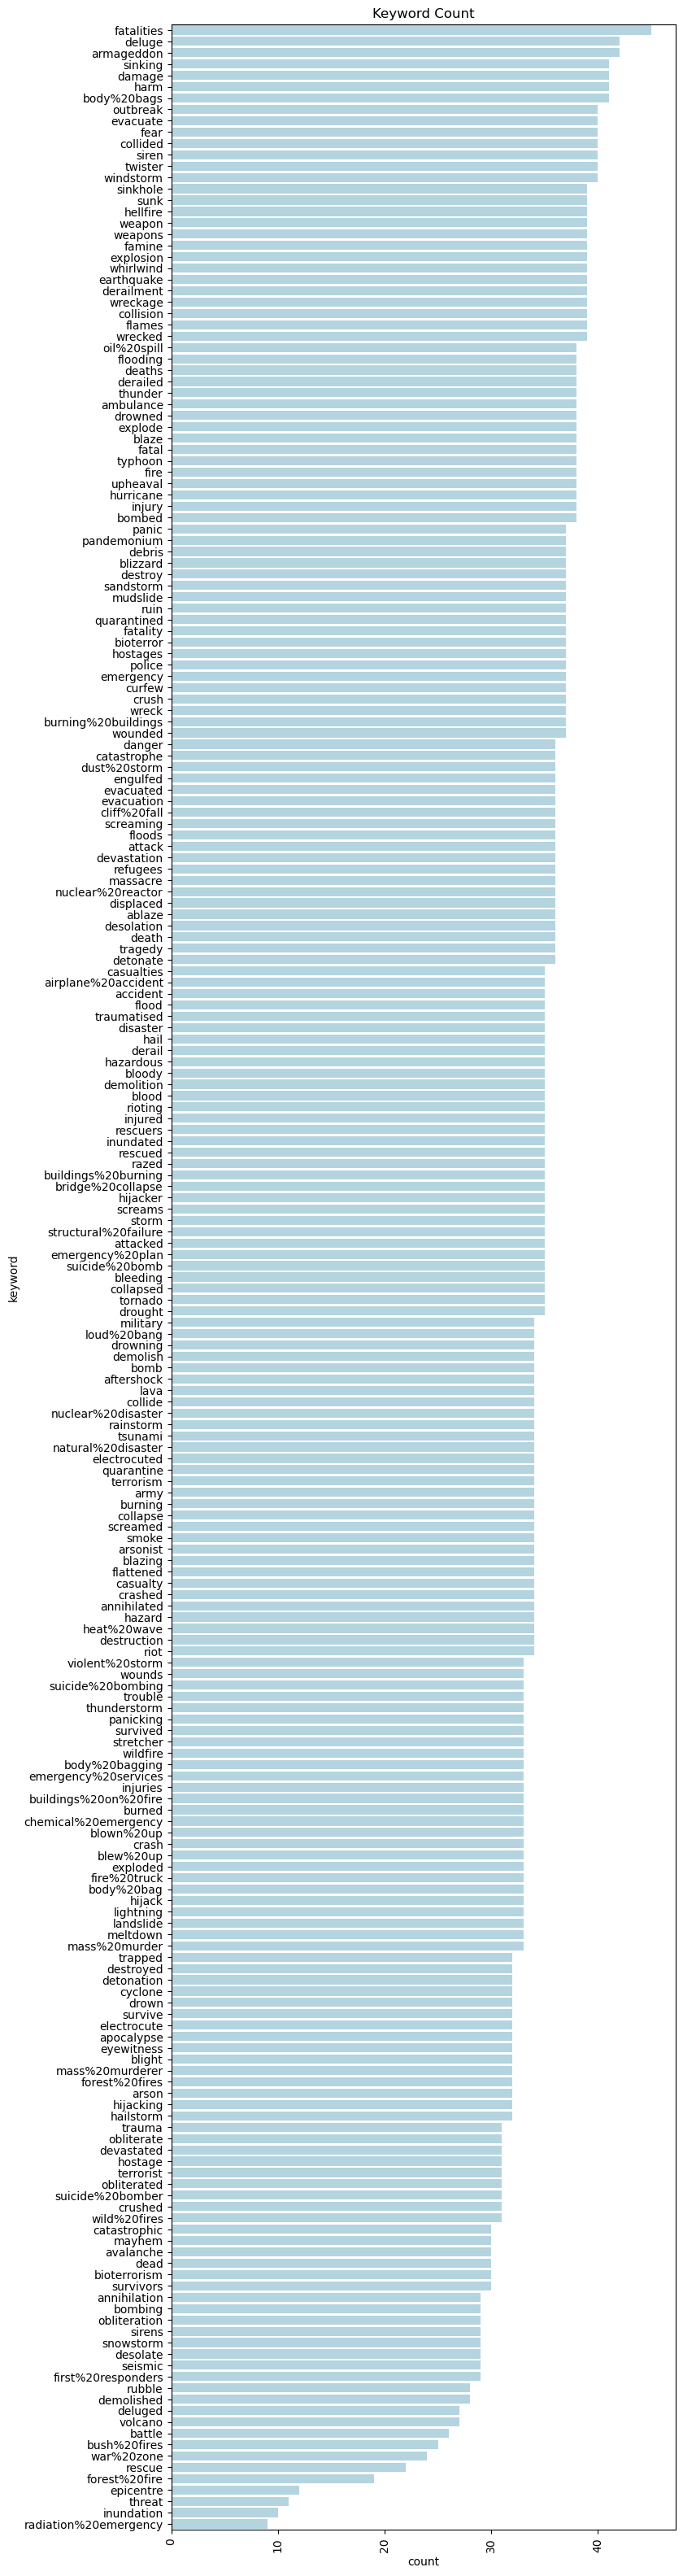

In [14]:
plt.figure(figsize=[8, 40])
sns.countplot(y='keyword',
              data=df_train,
              color='lightblue',
              order=df_train['keyword'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Keyword Count")
plt.show()

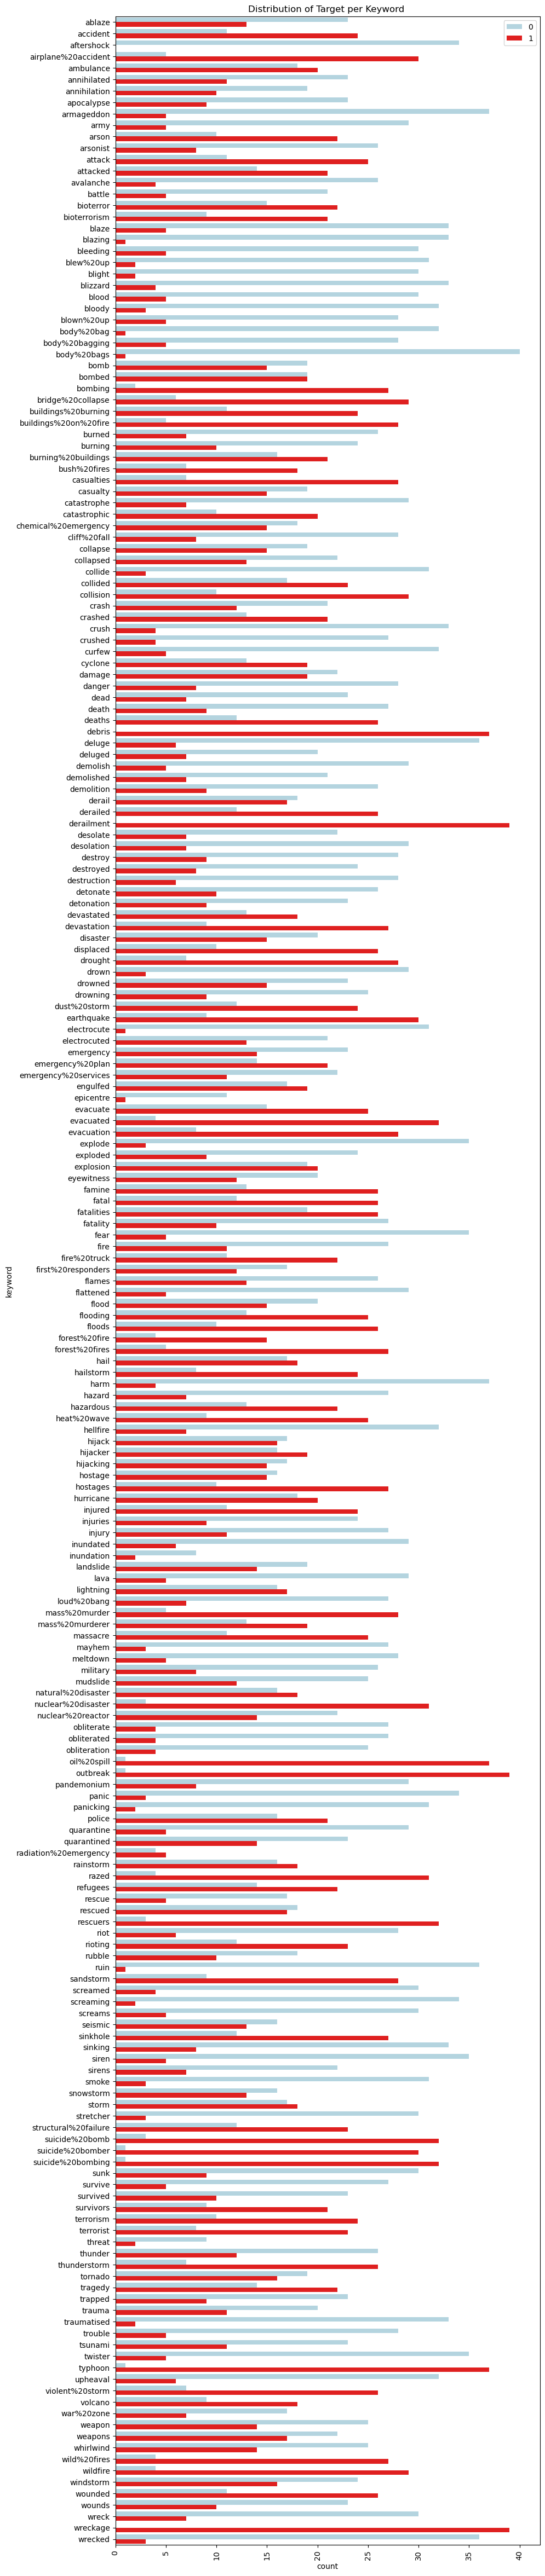

In [15]:
plt.figure(figsize=[10, 60])
sns.countplot(y='keyword', 
              hue='target', 
              data=df_train, 
              palette=['lightblue', 'red']
             )
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.title("Distribution of Target per Keyword ")
plt.show()

Substring "%20" in keywords looks a little bit strange, so I want to replace it with ' '. The graph above shows that for many keywords the target has a very clear distribution, for example for . Let's show the distribution for each keyword. Also, it's possible to create a table with a fraction of true disasters for each keyword for better understanding.

In [16]:
df_train.keyword = df_train.keyword.str.replace('%20', ' ')

In [17]:
# Let's show most common keywords for target = 1
df_train[df_train.target == 1].keyword.value_counts()[:10]

derailment         39
wreckage           39
outbreak           39
debris             37
oil spill          37
typhoon            37
evacuated          32
suicide bombing    32
rescuers           32
suicide bomb       32
Name: keyword, dtype: int64

In [18]:
# Let's show most common keywords for target = 1
df_train[df_train.target == 0].keyword.value_counts()[:10]

body bags     40
harm          37
armageddon    37
wrecked       36
ruin          36
deluge        36
explode       35
twister       35
fear          35
siren         35
Name: keyword, dtype: int64

In [19]:
df_train_group = df_train.groupby(['keyword', 'target'])['id'].count().unstack(fill_value=0).reset_index()
df_train_group.columns = ['keyword', 'target_0', 'target_1']
df_train_group['prob_real_disasters'] = df_train_group.target_1/(df_train_group.target_0 + df_train_group.target_1)

In [20]:
df_train_group.sort_values('prob_real_disasters', ascending=False)

keyword  target_0  target_1  prob_real_disasters
62       debris         0        37             1.000000
219    wreckage         0        39             1.000000
70   derailment         0        39             1.000000
153    outbreak         1        39             0.975000
152   oil spill         1        37             0.973684
..          ...       ...       ...                  ...
27     body bag        32         1             0.030303
19      blazing        33         1             0.029412
170        ruin        36         1             0.027027
29    body bags        40         1             0.024390
2    aftershock        34         0             0.000000

[221 rows x 4 columns]

In [21]:
df_train.keyword.nunique()

221

## Target Analysis

In [22]:
df_train.target.value_counts()/len(df_train)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [23]:
## This data set is unbalanced, so we should remember about it later

# Location Analysis

In [24]:
df_train.location.nunique()

3341

In [25]:
df_location = df_train.loc[:, ['id', 'target', 'location', 'text']]

In [26]:
df_location.location.fillna('no_location', inplace=True)

In [27]:
# Write a function to display basic entity info:
def show_ents(doc):
    doc = nlp(doc)
    count_GPE = 0
    if doc.ents:
        for ent in doc.ents:
            if ent.label_ == 'GPE':
                #print(ent.text+' - '+ent.label_+' - '+str(spacy.explain(ent.label_)))
                count_GPE = 1
                break
    return count_GPE

In [28]:
df_location['GPE_loc_flag'] = df_location.location.apply(show_ents)

In [29]:
df_location['GPE_text_flag'] = df_location.text.apply(show_ents)

In [30]:
df_location['GPE_flag'] = df_location.GPE_loc_flag | df_location.GPE_text_flag

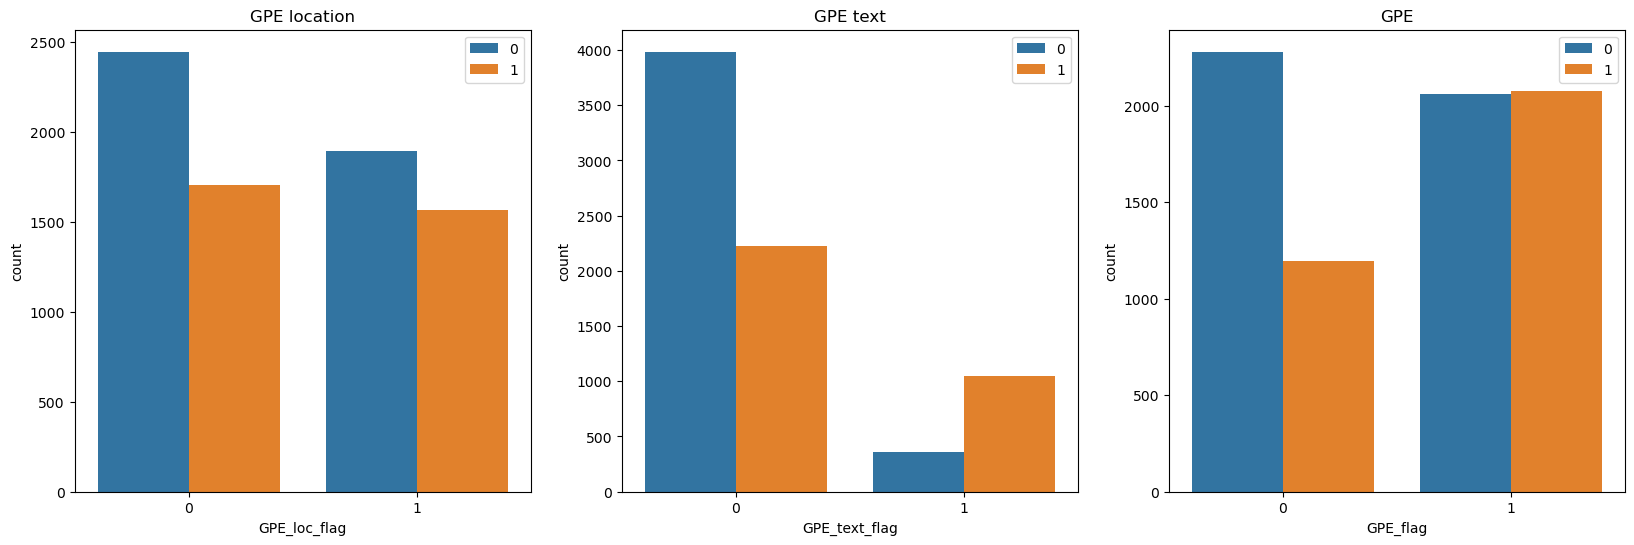

In [31]:
f, axes = plt.subplots(1, 3, figsize=(20,6))
sns.countplot(x='GPE_loc_flag', hue='target', data=df_location, ax=axes[0])
sns.countplot(x='GPE_text_flag', hue='target', data=df_location, ax=axes[1])
sns.countplot(x='GPE_flag', hue='target', data=df_location, ax=axes[2])
axes[0].set_title('GPE location')
axes[1].set_title('GPE text')
axes[2].set_title('GPE')

#plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
axes[0].legend(labels=['0', '1'])
axes[1].legend(labels=['0', '1'])
axes[2].legend(labels=['0', '1'])

plt.show()

In [32]:
# Looks like the location extracted from the tweet will be more informative than the original location feature.
df_location.iloc[:, -4:].corr()

GPE_loc_flag  GPE_text_flag  GPE_flag
GPE_loc_flag       1.000000       0.058926  0.836670
GPE_text_flag      0.058926       1.000000  0.435006
GPE_flag           0.836670       0.435006  1.000000

In [33]:
df_location

id  target     location  \
0         1       1  no_location   
1         4       1  no_location   
2         5       1  no_location   
3         6       1  no_location   
4         7       1  no_location   
...     ...     ...          ...   
7608  10869       1  no_location   
7609  10870       1  no_location   
7610  10871       1  no_location   
7611  10872       1  no_location   
7612  10873       1  no_location   

                                                                                                                                           text  \
0                                                                         Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                        Forest fire near La Ronge Sask. Canada   
2         All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                             13,000 people receive #wildfires evacuation orders in California    
4                                                      Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    
...                                                                                                                                         ...   
7608                                                        Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5   
7609              @aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.   
7610                                                                          M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ   
7611  Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.   
7612                                             The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d   

      GPE_loc_flag  GPE_text_flag  GPE_flag  
0                0              0         0  
1                0              1         1  
2                0              0         0  
3                0              1         1  
4                0              1         1  
...            ...            ...       ...  
7608             0              0         0  
7609             0              1         1  
7610             0              0         0  
7611             0              1         1  
7612             0              0         0  

[7613 rows x 7 columns]

## Feature Engineering

In [34]:
df_punct_fe = df_train.loc[:, ['id', 'target', 'text']]

In [35]:
#string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def count_punctuations(text):
    d=dict()
    for i in string.punctuation:
        d[str(i)+' count']=text.count(i)
    return d

In [36]:
df_punct_fe['punct_count'] = df_punct_fe["text"].apply(lambda x:count_punctuations(x))
df_punct= pd.DataFrame(list(df_punct_fe.punct_count))
merge_df = pd.merge(df_punct_fe.target,df_punct,left_index=True, right_index=True)

In [37]:
merge_df_gr = merge_df.groupby('target').sum().reset_index()
merge_df_gr = merge_df_gr.T
merge_df_gr.columns = ['target_0', 'target_1']

In [38]:
merge_df_gr

target_0  target_1
target          0         1
! count       843       330
" count         0         0
# count      1700      1703
$ count        32        12
% count        19        27
& count       293       164
' count      2063      1094
( count       207       142
) count       229       144
* count       121        58
+ count        57        23
, count         0         2
- count       810       943
. count      5752      5944
/ count      6798      7787
: count      3079      3831
; count       336       251
< count         0         0
= count        29        24
> count         0         1
? count      2364       762
@ count      1854       905
[ count        71        61
\ count         5         0
] count        72        59
^ count         2         4
_ count       538       325
` count         1         2
{ count         1         2
| count        99        53
} count         2         2
~ count        17        20

In [39]:
merge_df_gr['sum_0_1'] = merge_df_gr['target_0'] + merge_df_gr['target_1']

In [40]:
merge_df_gr[merge_df_gr.sum_0_1 > 1000]

target_0  target_1  sum_0_1
! count       843       330     1173
# count      1700      1703     3403
' count      2063      1094     3157
- count       810       943     1753
. count      5752      5944    11696
/ count      6798      7787    14585
: count      3079      3831     6910
? count      2364       762     3126
@ count      1854       905     2759

In [41]:
merge_df_gr[merge_df_gr.sum_0_1 > 1000]

target_0  target_1  sum_0_1
! count       843       330     1173
# count      1700      1703     3403
' count      2063      1094     3157
- count       810       943     1753
. count      5752      5944    11696
/ count      6798      7787    14585
: count      3079      3831     6910
? count      2364       762     3126
@ count      1854       905     2759

Our train dataset has 7613 samples so rare punctuation characters are not very informative. From the table above we cat see the most common  characters of real and fake disasters. Most of them have the same distribution, but symbols: !, ?, ', @ are havely used for usual tweets (not for disasters). Let's add the count of them as new columns (exept @, will analisys later).

In [42]:
def punct_add_exclamation(text):
    return len(re.findall("!", text))

In [43]:
def punct_add_question(text):
    return len(re.findall("\?", text))

In [44]:
def punct_add_quotation(text):
    return len(re.findall("'", text))

In [45]:
df_punct_fe['count_exclamation'] = df_punct_fe.text.apply(punct_add_exclamation)
df_punct_fe['count_question'] = df_punct_fe.text.apply(punct_add_question)
df_punct_fe['count_quotation'] = df_punct_fe.text.apply(punct_add_quotation)

In [46]:
new_cols = ['count_exclamation', 'count_question', 'count_quotation']

In [47]:
df_punct_fe.head(2)

id  target  \
0   1       1   
1   4       1   

                                                                    text  \
0  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                 Forest fire near La Ronge Sask. Canada   

                                                                                                                                                                                                                                                                                                                                                                                                                                                        punct_count  \
0  {'! count': 0, '" count': 0, '# count': 1, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0, '/ count': 0, ': count': 0, '; count': 0, '< count': 0, '= count': 0, '> count': 0, '? count': 0, '@ count': 0, '[ count': 0, '\ count': 0, '] count': 0, '^ count': 0, '_ count': 0, '` count': 0, '{ count': 0, '| count': 0, '} count': 0, '~ count': 0}   
1  {'! count': 0, '" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 1, '/ count': 0, ': count': 0, '; count': 0, '< count': 0, '= count': 0, '> count': 0, '? count': 0, '@ count': 0, '[ count': 0, '\ count': 0, '] count': 0, '^ count': 0, '_ count': 0, '` count': 0, '{ count': 0, '| count': 0, '} count': 0, '~ count': 0}   

   count_exclamation  count_question  count_quotation  
0                  0               0                0  
1                  0               0                0

In [48]:
# count number of characters 
def count_chars(text):
    return len(text)

# count number of words 
def count_words(text):
    return len(text.split())

# count number of capital characters
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

# count number of capital words
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

# count number of punctuations
def count_punctuations(text):
    count = lambda l1,l2: sum([1 for x in l1 if x in l2])
    return count(text,set(string.punctuation))

# count number of words in quotes
def count_words_in_quotes(text):
    string_wothout_contractions = ''
    expanded_words = []  
    for each_word in text.split():
        expanded_words.append(contractions.fix(each_word))
    string_wothout_contractions = ' '.join(expanded_words)
    string_wothout_contractions = string_wothout_contractions.replace('"', '\'')
    x = re.findall("\'(.+?)\'", string_wothout_contractions)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count
    
# count number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

# count number of unique words 
def count_unique_words(text):
    return len(set(text.split()))
    
# count of hashtags
def count_htags(text):
    x = re.findall(r'(\#\w[A-Za-z0-9]*)', text)
    return len(x)

# count of mentions
def count_mentions(text):
    x = re.findall(r'(\@\w[A-Za-z0-9]*)', text)
    return len(x)

# count of stopwords
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

#count of links
def count_links(text):
    link_list = re.findall(r'(https?://[^\s]+)', text)
    bitly_list = re.findall(r'bit.ly/\S+', text)
    return (len(link_list + bitly_list))

#count digits
def count_digits(text):
    digit_list = re.findall(r'[0-9]+', text)
    return len(digit_list)

# Factorize repeated punctuation, add REPEAT
def count_repeat_punct(text):
    rep_list = re.findall(r'([!?.]){2,}', text)
    return len(rep_list)

In [49]:
def feature_eng_fun(df_in, text):
    df = copy.deepcopy(df_in)
    df['count_exclamation'] = df_train[text].apply(punct_add_exclamation)
    df['count_question'] = df[text].apply(punct_add_question)
    df['count_quotation'] = df[text].apply(punct_add_quotation)
    df['count_num_of_chars'] = df[text].apply(count_chars)
    df['count_num_of_words'] = df[text].apply(count_words)
    df['count_num_of_capital_chars'] = df[text].apply(count_capital_chars)
    df['count_num_of_capital_words'] = df[text].apply(count_capital_words)
    df['count_punct'] = df[text].apply(count_punctuations)
    df['count_words_in_quotes'] = df[text].apply(count_words_in_quotes)
    df['count_sent'] = df[text].apply(count_sent)
    df['count_unique_words'] = df[text].apply(count_unique_words)
    df['count_htags'] = df[text].apply(count_htags)
    df['count_mentions'] = df[text].apply(count_mentions)
    df['count_htags'] = df[text].apply(count_htags)
    df['count_stopwords'] = df[text].apply(count_stopwords)
    df['count_links'] = df[text].apply(count_links) 
    df['count_repeat_punct'] = df[text].apply(count_repeat_punct)    
    ## This function from part above
    df['GPE_text_flag'] = df[text].apply(show_ents)    
    return df

In [50]:
## .loc will create a new copy, not view
df_feature_eng = df_train.loc[:, ('id', 'text', 'target')]

In [51]:
df_feature_eng = feature_eng_fun(df_feature_eng, 'text')

In [52]:
df_feature_eng.drop(['text'], axis=1, inplace=True)

<AxesSubplot:>

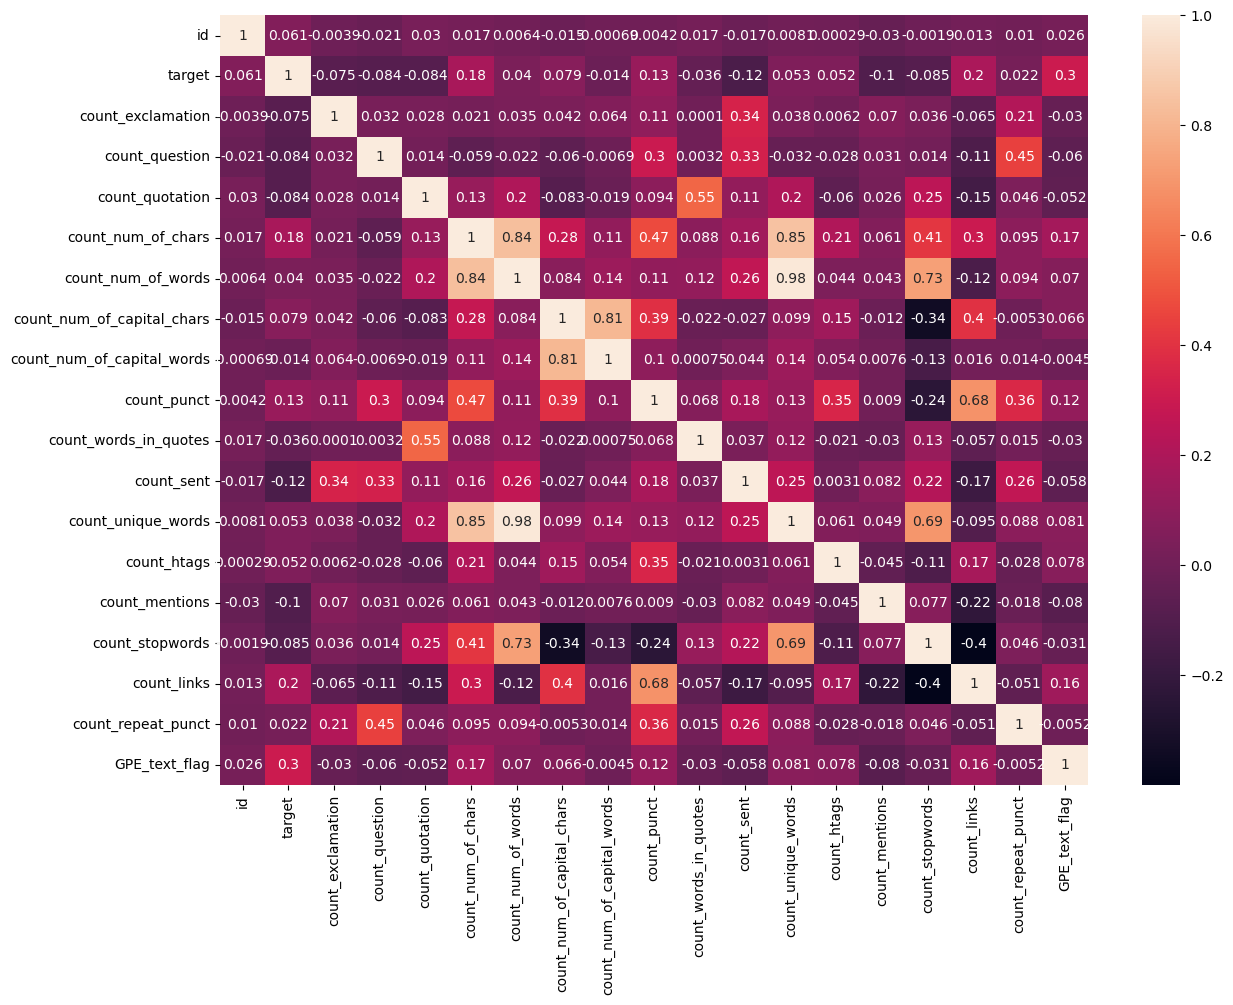

In [53]:
plt.figure(figsize=(14,10))
sns.heatmap(df_feature_eng.corr(),annot=True)

In [54]:
cols_selected = np.abs(df_feature_eng.corr()['target']).sort_values(ascending=False)[1:11].index.to_list()

In [55]:
df_feature_eng[cols_selected].head(3)

GPE_text_flag  count_links  count_num_of_chars  count_punct  count_sent  \
0              0            0                  69            1           1   
1              1            0                  38            1           2   
2              0            0                 133            3           2   

   count_mentions  count_stopwords  count_question  count_quotation  \
0               0                5               0                0   
1               0                0               0                0   
2               0                9               0                2   

   count_num_of_capital_chars  
0                          10  
1                           5  
2                           2

## Tweets text analysis

In [56]:
# Let's look at some tweets more carefully
df_train[55:60]

id keyword                      location  \
55  79  ablaze                           USA   
56  80  ablaze                  South Africa   
57  81  ablaze             Sao Paulo, Brazil   
58  82  ablaze                hollywoodland    
59  83  ablaze  Edmonton, Alberta - Treaty 6   

                                                                                                                                          text  \
55     #Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen Front in #Diyala http://t.co/4IzFdYC3cg   
56                                           TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF   
57                Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @Û_ https://t.co/cYoMPZ1A0Z   
58                     They sky was ablaze tonight in Los Angeles. I'm expecting IG and FB to be filled with sunset shots if I know my peeps!!   
59  How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd   

    target  
55       1  
56       1  
57       0  
58       0  
59       1

### Text Preprocessing Functions

In [57]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [58]:
#remove urls
def delete_not_ascii(text):
    text = re.sub(r'[^\x00-\x7f]', '', text)
    return text 

#remove urls
def remove_urls(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def replace_mention(text):
    pat=re.compile(r'@\S+')
    return pat.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)


##remove digits
#def remove_digits(text):
#    text = re.sub(r'[0-9]+', '', text)
#    return text   

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

#remove punctuation
def remove_punct(text):
    text = re.sub('[' + string.punctuation +']', ' ', text)
    return text     

# remove line breaks and extra spaces
def clean_text(text):
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

def convert_lower_case(text):
    return text.lower()

#contractions and remowing stopwords and very short words
def string_contractions(text):
    string_wothout_contractions = ''
    expanded_words = []  
    for each_word in text.split():
        if each_word not in (STOPWORDS):
            if len(each_word) >= 3:
                expanded_words.append(contractions.fix(each_word))
    string_wothout_contractions = ' '.join(expanded_words)
    return string_wothout_contractions



In [59]:
def basic_cleaning(df_in, column_name):
    df = copy.deepcopy(df_in)
    df[column_name] = df[column_name].apply(delete_not_ascii)
    df[column_name] = df[column_name].apply(remove_urls)
    df[column_name] = df[column_name].apply(replace_abbrev)
    df[column_name] = df[column_name].apply(replace_mention) 
    df[column_name] = df[column_name].apply(remove_number)
    df[column_name] = df[column_name].apply(remove_emoji)
    
    df[column_name] = df[column_name].apply(clean_text)
    df[column_name] = df[column_name].apply(convert_lower_case)
    df[column_name] = df[column_name].apply(string_contractions)
   # df['column_token'] = df[column_name].apply(word_tokenize)
    df[column_name] = df[column_name].apply(remove_punct)
    return df
    

In [60]:
df_text = df_train.loc[:, ['id', 'target', 'keyword', 'text']]

In [61]:
df_text = basic_cleaning(df_text, 'text')

In [62]:
df_text[df_text.text.str.contains('fifa')]

id  target   keyword  \
3323  4759       0  evacuate   
6677  9568       0   thunder   

                                                                                              text  
3323  wow   fifanumber pre season tournaments career mode  bloody hell evacuate building  whocares  
6677                           okay maybe extreme thunder lightning pretty much types   fifanumber

In [63]:
df_train[df_train.text.str.contains('FIFA')]

id   keyword         location  \
3323  4759  evacuate  London, England   
6677  9568   thunder           London   

                                                                                                                      text  \
3323                   Wow. #FIFA16 has Pre Season Tournaments in Career Mode. Bloody hell evacuate the building #whocares   
6677  Okay maybe not as extreme as thunder and lightning but pretty much all other types! #FIFA16  https://t.co/ETuuYISLHw   

      target  
3323       0  
6677       0

In [ ]:
df_train[df_train.id == 4995]

### OOV

In [64]:
all_text = ' '.join(df_text['text'].tolist())

In [65]:
oov_list = []
def search_oov(text):
    tokens = nlp(text)
    for token in tokens:
        if token.is_oov:
            oov_list.append(token)

In [66]:
search_oov(all_text)

In [67]:
oov_list_strings  = [i.text for i in oov_list]

In [68]:
counter = Counter(oov_list_strings)
counter.most_common(10)

[(' ', 10067),
 ('  ', 1336),
 ('   ', 693),
 ('    ', 403),
 ('     ', 160),
 ('mhnumber', 73),
 ('       ', 66),
 ('      ', 49),
 ('numberth', 45),
 ('numberpm', 36)]

### Sentiment Analyzer

In [69]:
sid = SentimentIntensityAnalyzer()

In [70]:
df_sentiment = df_train.loc[:, ['id', 'target', 'text']]

In [71]:
df_sentiment['sentiment_compound']  = df_sentiment.text.apply(lambda tweet: sid.polarity_scores(tweet)['compound'])

In [72]:
df_sentiment['sentiment_compound_score'] = df_sentiment['sentiment_compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

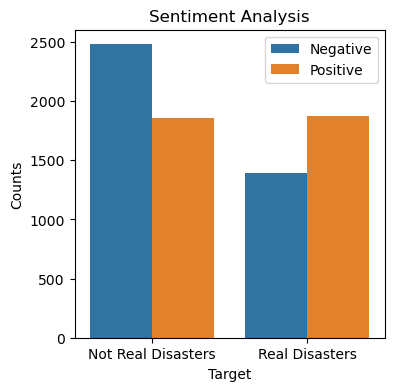

In [73]:
plt.figure(figsize=[4, 4])
sns.countplot(x='target', hue='sentiment_compound_score', data=df_sentiment)
plt.title('Sentiment Analysis')
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
plt.xlabel('Target')
plt.ylabel('Counts')
plt.legend(labels=['Negative', 'Positive'])
plt.show()

In [74]:
#not very optimistic result, I won't add a sentiment feature :)

In [75]:
## CREATE A MODEL BASED ON TEXT

1. Based on text only
2. Based on text and new features

In [76]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def best_tresholds(y_pred_proba, y_test):
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(y_pred_proba, t)) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)
    #print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return thresholds[ix], scores[ix]

In [ ]:
### with eng features

In [77]:
df_copy = copy.deepcopy(df_train)

In [79]:
cols_selected = ['GPE_text_flag', 'count_links', 'count_num_of_chars', 'count_punct', 'count_sent',
                 'count_mentions', 'count_stopwords', 'count_question', 'count_quotation',
                 'count_num_of_capital_chars']

df_copy = copy.deepcopy(df_train)
df_train_text_clean = basic_cleaning(df_copy, 'text')
df_train_text_clean["clean_text"] = df_train_text_clean.keyword.map(str) + " " + df_train_text_clean.text

## new features
df_train_feature_eng = feature_eng_fun(df_copy, 'text')
df_train_feature_eng = df_train_feature_eng[cols_selected]


#### for test
df_test_text_clean_f = basic_cleaning(df_test, 'text')
df_test_text_clean_f["clean_text"] = df_test_text_clean_f.keyword.map(str) + " " + df_test_text_clean_f.text

df_test_feature_eng_f = feature_eng_fun(df_test, 'text')
df_test_feature_eng_f = df_test_feature_eng_f[cols_selected]

In [80]:
df_train_text_clean.shape

(7613, 6)

In [81]:
df_train_feature_eng.shape

(7613, 10)

In [82]:
df_train_full = pd.merge(df_train_text_clean[['target', 'clean_text']], df_train_feature_eng, 
                         left_index=True, right_index=True)

df_test_full = pd.merge(df_test_text_clean_f[['clean_text']], df_test_feature_eng_f, 
                         left_index=True, right_index=True)

In [83]:
## split to test and train
y = df_train_full['target']
X = df_train_full.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)

X_train shape (5329, 11)
X_test shape (2284, 11)


In [99]:
max_features=5000

# CountVectorizer
count_vectorizer = CountVectorizer(max_features=max_features)

def count_vector(data):
    count_vectorizer = CountVectorizer()
    vect = count_vectorizer.fit_transform(data)
    return vect, count_vectorizer

def tfidf_vector(data):
    tfidf_vectorizer = TfidfVectorizer()
    vect = tfidf_vectorizer.fit_transform(data)
    return vect, tfidf_vectorizer

def min_max(data):
    min_max_scaler = MinMaxScaler()
    vect = min_max_scaler.fit_transform(data)
    return vect, min_max_scaler

X_train_count, count_vectorizer = count_vector(X_train['clean_text'])
X_train_tfidf, tfidf_vectorizer = tfidf_vector(X_train['clean_text'])

X_train_eng_minmax, minmax_scaler = min_max(X_train[cols_selected])
X_train_eng = X_train[cols_selected].to_numpy()

#### TEST
X_test_count = count_vectorizer.transform(X_test ['clean_text'])                                                     
X_test_tfidf = tfidf_vectorizer.transform(X_test ['clean_text'])

X_test_eng_minmax = minmax_scaler.transform(X_test[cols_selected])
X_test_eng = X_test[cols_selected].to_numpy()

### TEST DATASET
X_test_count_f = count_vectorizer.transform(df_test_full['clean_text'])                                                     
X_test_tfidf_f = tfidf_vectorizer.transform(df_test_full['clean_text'])

X_test_eng_minmax_f = minmax_scaler.transform(df_test_full[cols_selected])
X_test_eng_f = df_test_full[cols_selected].to_numpy()


### CONCAT tf-idf + minmax, count_vec + feature_eng

X_train_tfidf_minmax = hstack([X_train_tfidf, X_train_eng_minmax])
X_train_count_eng = hstack([X_train_count, X_train_eng])


X_test_tfidf_minmax = hstack([X_test_tfidf, X_test_eng_minmax])
X_test_count_eng = hstack([X_test_count, X_test_eng])

X_test_tfidf_minmax_f = hstack([X_test_tfidf_f, X_test_eng_minmax_f])
X_test_count_eng_f = hstack([X_test_count_f, X_test_eng_f])

In [ ]:
import pickle
from joblib import dump

In [ ]:
with open('count_vectorizer.pickle', 'wb') as handle:
    pickle.dump(count_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tfidf_vectorizer.pickle', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('minmax_scaler.pickle', 'wb') as handle:
    pickle.dump(minmax_scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [110]:
metrics = pd.DataFrame(columns=['model' ,'vectoriser', 'f1 score', 'best_f1', 'threshold', 
                                'train accuracy','test accuracy'])

In [111]:
def fit_and_predict(model, x_train ,x_test, y_train, y_test, vectoriser):
    classifier = model
    classifier_name = str(classifier.__class__.__name__)


    classifier.fit(x_train,y_train)

    y_pred = classifier.predict(x_test)
    cmatrix = confusion_matrix(y_test,y_pred)
    
    y_hat = classifier.predict_proba(x_test)[:,1]
    threshold, best_score = best_tresholds(y_hat, y_test)


    f1score = f1_score(y_test,y_pred)
    train_accuracy = round(classifier.score(x_train,y_train)*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred)*100)

    global metrics
    metrics = metrics.append({
                              'model': classifier_name,
                              'f1 score': f1score, 
                              'best_f1': best_score,
                              'threshold': threshold,
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                              'vectoriser': str(vectoriser),
                             },
                               ignore_index=True
                            )

    print(str(classifier.__class__.__name__) +" using "+ str(vectoriser))
    print('f1 score for test: {}'.format(f1score))
    print(classification_report(y_test,y_pred))    
    print('Threshold={:.5f}, F-Score={:.5f}'.format(threshold, best_score))
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [113]:
models=[
   #     XGBClassifier(max_depth=6, n_estimators=1000),
        LogisticRegression(random_state=30),
        SVC(random_state=30, probability=True),
        MultinomialNB(),
        DecisionTreeClassifier(random_state = 30),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=30),
       ]

In [114]:
for model in models:
    ## only text Count vector
    fit_and_predict(model, X_train_count, X_test_count, y_train ,y_test, 'Count vector')
    
    fit_and_predict(model, X_train_tfidf, X_test_tfidf, y_train, y_test, 'Tfidf vector')
    
    ## count with EF
    fit_and_predict(model, X_train_count_eng, X_test_count_eng, y_train, y_test, 'Count vector + FE')
    
    ## TF IDF with EF
    fit_and_predict(model, X_train_tfidf_minmax, X_test_tfidf_minmax, y_train, y_test, 'TF-IDF + FE')   

C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


LogisticRegression using Count vector
f1 score for test: 0.7508125677139762
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1318
           1       0.79      0.72      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284

Threshold=0.44100, F-Score=0.75794
Accuracy of classifier on training set:96%
Accuracy of classifier on test set:80%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


LogisticRegression using Tfidf vector
f1 score for test: 0.7461368653421633
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1318
           1       0.80      0.70      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284

Threshold=0.48300, F-Score=0.75376
Accuracy of classifier on training set:88%
Accuracy of classifier on test set:80%


C:\Users\Me\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


LogisticRegression using Count vector + FE
f1 score for test: 0.736950904392765
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1318
           1       0.74      0.74      0.74       966

    accuracy                           0.78      2284
   macro avg       0.77      0.77      0.77      2284
weighted avg       0.78      0.78      0.78      2284

Threshold=0.48000, F-Score=0.74198
Accuracy of classifier on training set:82%
Accuracy of classifier on test set:78%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


LogisticRegression using TF-IDF + FE
f1 score for test: 0.7502750275027503
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1318
           1       0.80      0.71      0.75       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284

Threshold=0.41100, F-Score=0.76511
Accuracy of classifier on training set:87%
Accuracy of classifier on test set:80%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


SVC using Count vector
f1 score for test: 0.7376209447922596
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1318
           1       0.82      0.67      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284

Threshold=0.41600, F-Score=0.76538
Accuracy of classifier on training set:94%
Accuracy of classifier on test set:80%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


SVC using Tfidf vector
f1 score for test: 0.7414852037967614
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284

Threshold=0.45500, F-Score=0.75743
Accuracy of classifier on training set:95%
Accuracy of classifier on test set:80%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


SVC using Count vector + FE
f1 score for test: 0.5409652076318743
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1318
           1       0.59      0.50      0.54       966

    accuracy                           0.64      2284
   macro avg       0.63      0.62      0.62      2284
weighted avg       0.64      0.64      0.64      2284

Threshold=0.31000, F-Score=0.64213
Accuracy of classifier on training set:64%
Accuracy of classifier on test set:64%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


SVC using TF-IDF + FE
f1 score for test: 0.7540255413659078
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1318
           1       0.81      0.70      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.80      2284
weighted avg       0.81      0.81      0.80      2284

Threshold=0.39700, F-Score=0.76291
Accuracy of classifier on training set:92%
Accuracy of classifier on test set:81%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


MultinomialNB using Count vector
f1 score for test: 0.7593470247498683
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1318
           1       0.77      0.75      0.76       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284

Threshold=0.39100, F-Score=0.76215
Accuracy of classifier on training set:90%
Accuracy of classifier on test set:80%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


MultinomialNB using Tfidf vector
f1 score for test: 0.7386363636363636
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1318
           1       0.82      0.67      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284

Threshold=0.37600, F-Score=0.75407
Accuracy of classifier on training set:88%
Accuracy of classifier on test set:80%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


MultinomialNB using Count vector + FE
f1 score for test: 0.7535321821036106
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1318
           1       0.76      0.75      0.75       966

    accuracy                           0.79      2284
   macro avg       0.79      0.79      0.79      2284
weighted avg       0.79      0.79      0.79      2284

Threshold=0.41100, F-Score=0.75787
Accuracy of classifier on training set:88%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


MultinomialNB using TF-IDF + FE
f1 score for test: 0.7399553571428572
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1318
           1       0.80      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284

Threshold=0.40200, F-Score=0.75730
Accuracy of classifier on training set:86%
Accuracy of classifier on test set:80%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


DecisionTreeClassifier using Count vector
f1 score for test: 0.679745493107105
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1318
           1       0.70      0.66      0.68       966

    accuracy                           0.74      2284
   macro avg       0.73      0.73      0.73      2284
weighted avg       0.73      0.74      0.73      2284

Threshold=0.33400, F-Score=0.68346
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:74%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


DecisionTreeClassifier using Tfidf vector
f1 score for test: 0.6715712033631109
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1318
           1       0.68      0.66      0.67       966

    accuracy                           0.73      2284
   macro avg       0.72      0.72      0.72      2284
weighted avg       0.73      0.73      0.73      2284

Threshold=0.33400, F-Score=0.67636
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:73%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


DecisionTreeClassifier using Count vector + FE
f1 score for test: 0.6324324324324324
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1318
           1       0.66      0.61      0.63       966

    accuracy                           0.70      2284
   macro avg       0.69      0.69      0.69      2284
weighted avg       0.70      0.70      0.70      2284

Threshold=0.42900, F-Score=0.63592
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:70%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


DecisionTreeClassifier using TF-IDF + FE
f1 score for test: 0.6348012889366272
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1318
           1       0.66      0.61      0.63       966

    accuracy                           0.70      2284
   macro avg       0.69      0.69      0.69      2284
weighted avg       0.70      0.70      0.70      2284

Threshold=0.33400, F-Score=0.63631
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:70%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


KNeighborsClassifier using Count vector
f1 score for test: 0.6325088339222615
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1318
           1       0.73      0.56      0.63       966

    accuracy                           0.73      2284
   macro avg       0.73      0.70      0.71      2284
weighted avg       0.73      0.73      0.72      2284

Threshold=0.20100, F-Score=0.65835
Accuracy of classifier on training set:81%
Accuracy of classifier on test set:73%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


KNeighborsClassifier using Tfidf vector
f1 score for test: 0.6925531914893617
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1318
           1       0.71      0.67      0.69       966

    accuracy                           0.75      2284
   macro avg       0.74      0.74      0.74      2284
weighted avg       0.75      0.75      0.75      2284

Threshold=0.20100, F-Score=0.69360
Accuracy of classifier on training set:82%
Accuracy of classifier on test set:75%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


KNeighborsClassifier using Count vector + FE
f1 score for test: 0.5444566410537871
              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1318
           1       0.58      0.51      0.54       966

    accuracy                           0.64      2284
   macro avg       0.63      0.62      0.62      2284
weighted avg       0.63      0.64      0.63      2284

Threshold=0.00100, F-Score=0.60846
Accuracy of classifier on training set:77%
Accuracy of classifier on test set:64%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


KNeighborsClassifier using TF-IDF + FE
f1 score for test: 0.7209062821833161
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1318
           1       0.72      0.72      0.72       966

    accuracy                           0.76      2284
   macro avg       0.76      0.76      0.76      2284
weighted avg       0.76      0.76      0.76      2284

Threshold=0.40100, F-Score=0.72091
Accuracy of classifier on training set:83%
Accuracy of classifier on test set:76%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


RandomForestClassifier using Count vector
f1 score for test: 0.715862870424172
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1318
           1       0.82      0.64      0.72       966

    accuracy                           0.79      2284
   macro avg       0.79      0.77      0.77      2284
weighted avg       0.79      0.79      0.78      2284

Threshold=0.37200, F-Score=0.74235
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:79%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


RandomForestClassifier using Tfidf vector
f1 score for test: 0.713631156930126
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1318
           1       0.80      0.64      0.71       966

    accuracy                           0.78      2284
   macro avg       0.79      0.76      0.77      2284
weighted avg       0.78      0.78      0.78      2284

Threshold=0.35400, F-Score=0.74314
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:78%


C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


RandomForestClassifier using Count vector + FE
f1 score for test: 0.6926889714993804
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1318
           1       0.86      0.58      0.69       966

    accuracy                           0.78      2284
   macro avg       0.81      0.76      0.76      2284
weighted avg       0.80      0.78      0.77      2284

Threshold=0.32200, F-Score=0.75448
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:78%
RandomForestClassifier using TF-IDF + FE
f1 score for test: 0.7003076923076924
              precision    recall  f1-score   support

           0       0.76      0.93      0.83      1318
           1       0.86      0.59      0.70       966

    accuracy                           0.79      2284
   macro avg       0.81      0.76      0.77      2284
weighted avg       0.80      0.79      0.78      2284

Threshold=0.33100, F-Score=0.75268
Accuracy of classifier on trai

C:\Users\Me\AppData\Local\Temp\ipykernel_29980\2469719882.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({


In [115]:
metrics.sort_values('best_f1')

model         vectoriser  f1 score   best_f1  threshold  \
18    KNeighborsClassifier  Count vector + FE  0.544457  0.608458      0.001   
14  DecisionTreeClassifier  Count vector + FE  0.632432  0.635925      0.429   
15  DecisionTreeClassifier        TF-IDF + FE  0.634801  0.636315      0.334   
6                      SVC  Count vector + FE  0.540965  0.642125      0.310   
16    KNeighborsClassifier       Count vector  0.632509  0.658349      0.201   
13  DecisionTreeClassifier       Tfidf vector  0.671571  0.676364      0.334   
12  DecisionTreeClassifier       Count vector  0.679745  0.683465      0.334   
17    KNeighborsClassifier       Tfidf vector  0.692553  0.693600      0.201   
19    KNeighborsClassifier        TF-IDF + FE  0.720906  0.720906      0.401   
2       LogisticRegression  Count vector + FE  0.736951  0.741985      0.480   
20  RandomForestClassifier       Count vector  0.715863  0.742354      0.372   
21  RandomForestClassifier       Tfidf vector  0.713631  0.743142      0.354   
23  RandomForestClassifier        TF-IDF + FE  0.700308  0.752677      0.331   
1       LogisticRegression       Tfidf vector  0.746137  0.753763      0.483   
9            MultinomialNB       Tfidf vector  0.738636  0.754066      0.376   
22  RandomForestClassifier  Count vector + FE  0.692689  0.754485      0.322   
11           MultinomialNB        TF-IDF + FE  0.739955  0.757301      0.402   
5                      SVC       Tfidf vector  0.741485  0.757433      0.455   
10           MultinomialNB  Count vector + FE  0.753532  0.757873      0.411   
0       LogisticRegression       Count vector  0.750813  0.757939      0.441   
8            MultinomialNB       Count vector  0.759347  0.762148      0.391   
7                      SVC        TF-IDF + FE  0.754026  0.762907      0.397   
3       LogisticRegression        TF-IDF + FE  0.750275  0.765114      0.411   
4                      SVC       Count vector  0.737621  0.765381      0.416   

   train accuracy test accuracy  
18             77            64  
14             99            70  
15             99            70  
6              64            64  
16             81            73  
13             99            73  
12             99            74  
17             82            75  
19             83            76  
2              82            78  
20             99            79  
21             99            78  
23             99            79  
1              88            80  
9              88            80  
22             99            78  
11             86            80  
5              95            80  
10             88            79  
0              96            80  
8              90            80  
7              92            81  
3              87            80  
4              94            80

In [118]:
lr = LogisticRegression(random_state=30)
lr.fit(X_train_tfidf_minmax, y_train)
y_pred_prob = lr.predict_proba(X_test_tfidf_minmax_f)[:, 1]

In [120]:
df_t = df_test[['id']]
df_t['target'] = (y_pred_prob >= 0.416).astype(int)

C:\Users\Me\AppData\Local\Temp\ipykernel_29980\928970408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['target'] = (y_pred_prob >= 0.416).astype(int)


In [121]:
df_t.to_csv("submission_logit_treshold_416.csv", index=False)